<a href="https://colab.research.google.com/github/MGherardi07/Big-Data-in-Physics/blob/master/Assignment_Week_2_exoplanet_A_(using_astroquery).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(1)Choose two random planet from Tess Project Candidates
(2)Obtain a light curves for each transiting exo-planet
(3)OPTIONAL: Obtain light curves for some interesting field star

In [66]:
!pip install astroquery
import numpy as np
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline

In [67]:
ticid = 206544316	

starName = "TIC " + str(ticid)
radSearch = 4/60 #radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first row in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

    ID      Tmag   Jmag         ra               dec        objType
--------- ------- ------ ---------------- ----------------- -------
206544316 11.6337  9.953 18.4180198356956 -59.6595635897008    STAR
206544310 13.8065 13.396 18.4379937897752 -59.6666180274539    STAR
615990175 18.1976    nan 18.4004532773069 -59.6493542591125    STAR
206544304 18.3768 16.509 18.4165325133968 -59.6736289577888    STAR
206544322 15.6363 14.431 18.4018510240209  -59.647058353309    STAR


In [68]:
# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 15

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)

12

In [69]:
coord = SkyCoord(ra, dec, unit = "deg")

sectorTable = Tesscut.get_sectors(coord)
print(sectorTable)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0001-3-1      1      3   1
tess-s0002-3-2      2      3   2


In [70]:
hdulist = Tesscut.get_cutouts(coord, 20)

hdulist[0].info()
hdulist[0][0].header['sector']

hdulist[1].info()
hdulist


Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   
Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1245R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   


[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7ff40f516860>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff40f5346d8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ff40ef2cb38>],
 [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7ff40f00ccc0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff40ef4c978>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ff40eeea828>]]

In [0]:
# Define a function to simplify the plotting command that we do repeatedly.
def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')

Text(0, 0.5, 'Image Row')

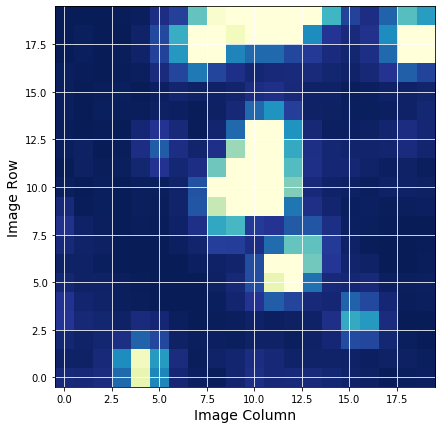

In [72]:
hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage)
plt.xlabel('Image Column',fontsize = 14)
plt.ylabel('Image Row',fontsize = 14)


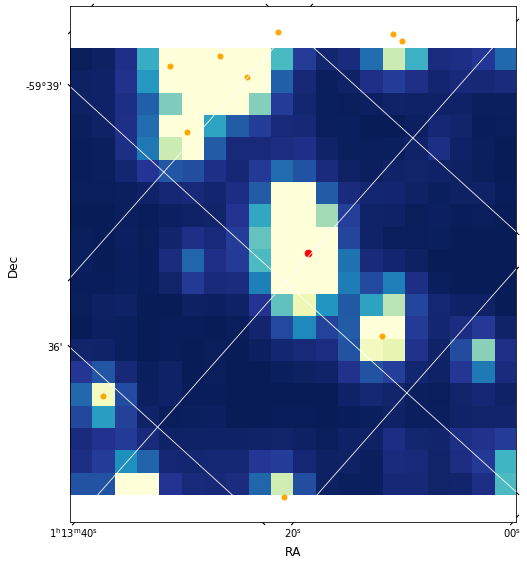

In [73]:
hdu2 = hdulist[1]

firstImage = hdu2[1].data['FLUX'][0]

wcs = WCS(hdu2[2].header)

fig = plt.figure(figsize = (8, 10))
fig.add_subplot(111, projection = wcs)
plot_cutout(firstImage)

plt.xlabel('RA', fontsize = 12)
plt.ylabel('Dec', fontsize = 12)


starloc = wcs.all_world2pix([[ra,dec]],0)  #Second is origin
plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:],0)
plt.scatter(nearbyLoc[1:, 0], nearbyLoc[1:, 1], 
            s = 25, color = 'orange')

In [0]:
def aperture_phot(image, aperture):
    """
    Sum-up the pixels that are in the aperture for one image.
    image and aperture are 2D arrays that need to be the same size.
    
    aperture is a boolean array where True means to include the light of those pixels.
    """
    flux = np.sum(image[aperture])

    return flux

def make_lc(flux_data, aperture):
    """
    Apply the 2d aperture array to the and time series of 2D images. 
    Return the photometric series by summing over the pixels that are in the aperture.
    
    Aperture is a boolean array where True means it is in the desired aperture.
    """
    
    flux = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )

    return flux

Text(0.5, 1.0, 'Flux in Photometric Aperture')

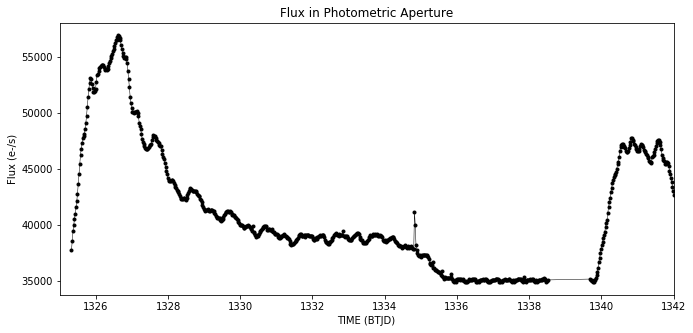

In [75]:
# Use all pixels in our aperture.
aperture = hdu1[2].data == 1

flux1 = make_lc(hdu1[1].data['FLUX'], aperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11,5))
plt.plot(time1, flux1, 'k.-', lw = .5)
plt.xlim(1325,1342)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Flux in Photometric Aperture')

Text(0.5, 1.0, 'Background Flux')

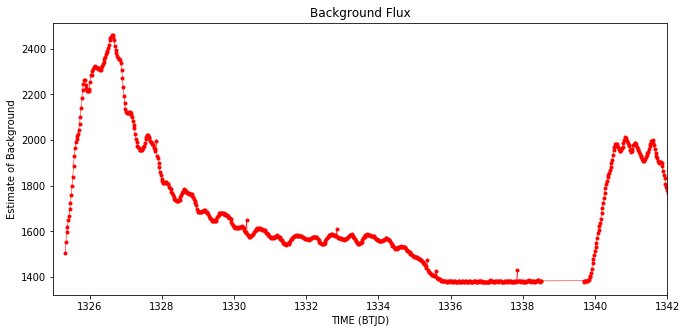

In [76]:
# Plot the flux change of the dimmest pixels by using percentile.
bkgAperture = hdu1[1].data['FLUX'][0] < np.percentile(hdu1[1].data['FLUX'][0], 5)

bkgFlux1 = make_lc(hdu1[1].data['FLUX'], bkgAperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11, 5))
plt.plot(time1, bkgFlux1, 'r.-', lw = .5)

plt.xlim(1325, 1342)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Estimate of Background')
plt.title('Background Flux')

Text(0.5, 1.0, 'Background Subtracted Flux')

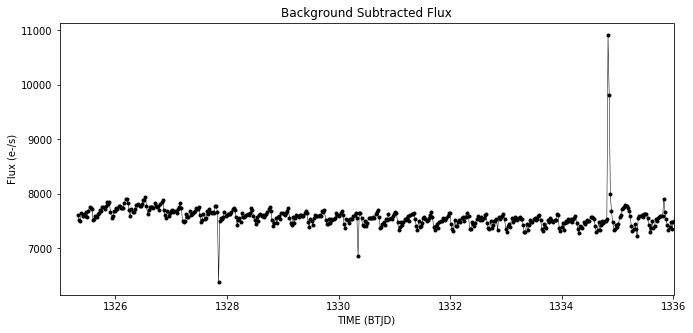

In [77]:
bkgSubFlux = flux1 - (bkgFlux1 * np.sum(aperture) / np.sum(bkgAperture) )

plt.figure(figsize = (11,5))
plt.plot(time1, bkgSubFlux,'.-k', lw = 0.5)

plt.xlim(1325, 1336)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Background Subtracted Flux')

Text(0.5, 1.0, 'Sampled - Background Subtracted Flux')

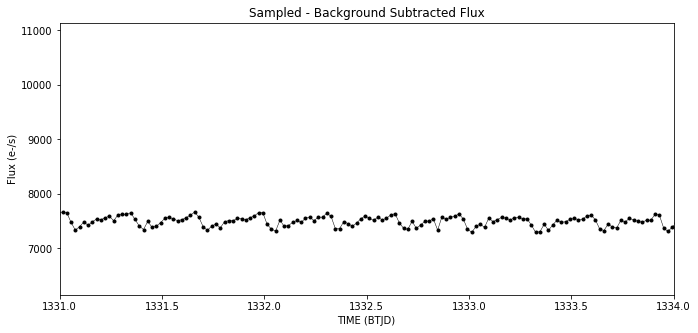

In [78]:
bkgSubFlux = flux1 - (bkgFlux1 * np.sum(aperture) / np.sum(bkgAperture) )

plt.figure(figsize = (11,5))
plt.plot(time1, bkgSubFlux,'.-k', lw = 0.5)

plt.xlim(1331, 1334)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Sampled - Background Subtracted Flux')